In [2]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import os.path as op
import shutil
import torch

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow import keras

In [2]:
%%capture
!gdown --id 1N1GDtYjj3_vdRTp6m310qj6p6f2HlwqK # cropped dataset
!gdown --id 1vNkspg4JwQXcQHG9oWQG3Fi8PfW5YDuD #align.json output from gentle forced aligner
!gdown --id 1Al6cVvChDvsQvoXHpEjOqDpUMdx
!rm -rf data/
!mkdir data/
!unzip cropped.zip -d data

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [8]:
df = pd.read_csv('drive/My Drive/AI-Builders/My Project/Data/data.csv')
df.loc[0]

Unnamed: 0             0
image         000001.jpg
phone               none
case              failed
Name: 0, dtype: object

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGHT = 4
CLASSES = 44

In [ ]:
len(os.listdir("data/cropped"))

131664

In [10]:
from matplotlib.image import imread
train = []
labels_train = []
sequence_num = 0
sequence = []
for i in range(len(os.listdir("data/cropped"))):
  sequence_num += 1
  if df.loc[i].case == "success":
    now_data = df.loc[i]
    previous_data = df.loc[i-1]
    sequence.append(cv2.resize(imread(f"data/cropped/{now_data.image}"), dsize=(64, 64), interpolation=cv2.INTER_CUBIC))
    if previous_data.phone != now_data.phone and len(sequence) < SEQUENCE_LENGHT:
      for n in range(SEQUENCE_LENGHT-len(sequence)):
        sequence.append(sequence[-1])
    if len(sequence) == SEQUENCE_LENGHT:
      train.append(sequence)
      labels_train.append(now_data.phone)
      sequence = []

In [11]:
from sklearn.preprocessing import LabelEncoder


labels_train = np.array(labels_train)
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(labels_train)
labels_train = to_categorical(labels_train)

In [ ]:
train[0]

In [6]:
def create_conv_lstm_model():
  model = Sequential()
  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGHT, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(MaxPooling3D(pool_size= (1, 2, 2), padding="same", data_format= "channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(40, activation="softmax"))

  model.summary()

  return model

In [12]:
convlstm_model = create_conv_lstm_model()
print("Model Created")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 4, 62, 62, 4)      1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 31, 31, 4)     0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 4, 31, 31, 4)     0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 4, 29, 29, 8)      3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 15, 15, 8)     0         
 3D)                                                             
                                                      

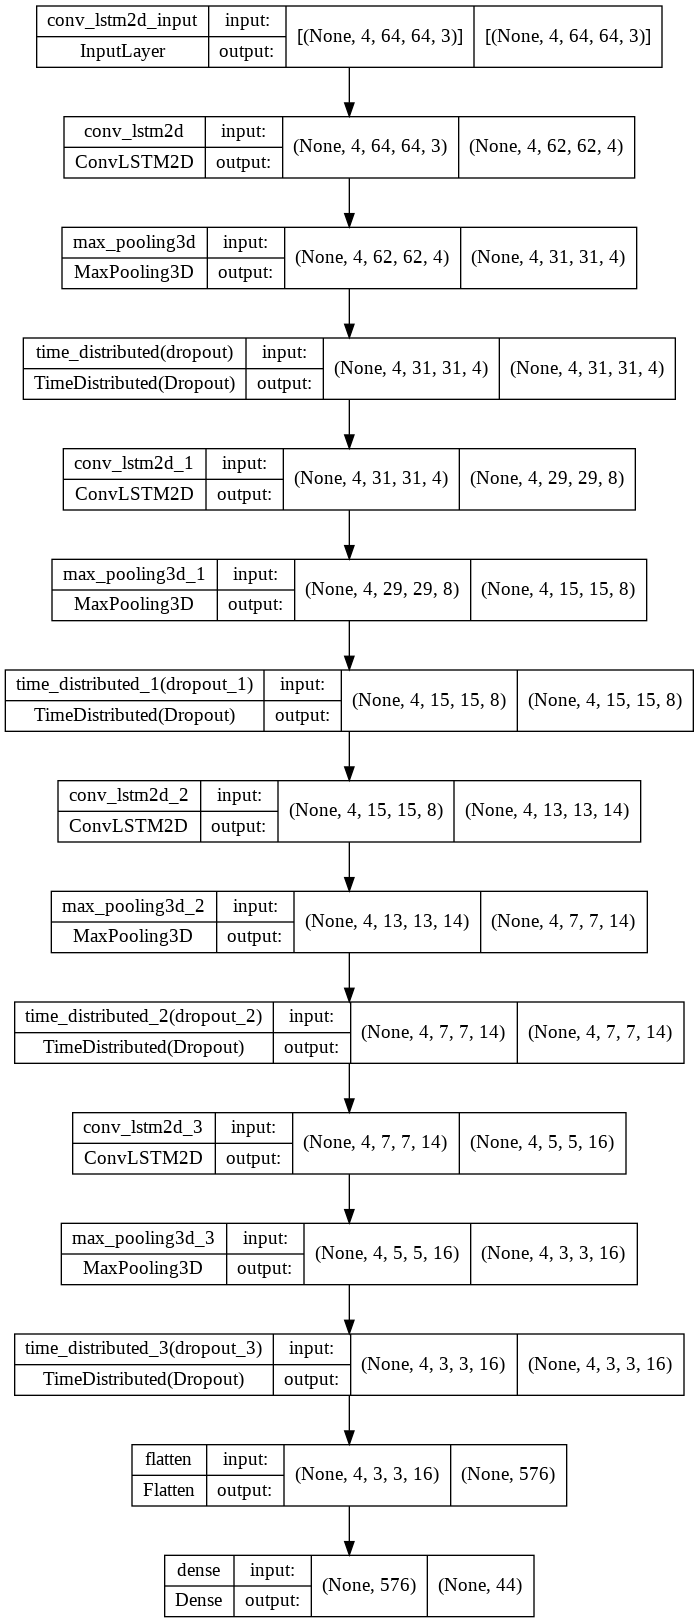

In [ ]:
plot_model(convlstm_model, to_file="convlstm_structure_plot.png", show_shapes=True, show_layer_names=True)

In [13]:
from tensorflow.keras.callbacks import Callback
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [ ]:
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="drive/My Drive/AI-Builders/My Project/Saved_Model/Newer",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
convlstm_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x=np.array(train), y=np.array(labels_train), epochs=20, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback, model_checkpoint_callback, ClearMemory()])

Epoch 1/20
8650/8650 [==============================] - 554s 63ms/step - loss: 2.3285 - accuracy: 0.3275 - val_loss: 2.3873 - val_accuracy: 0.3163
Epoch 2/20
8650/8650 [==============================] - 545s 63ms/step - loss: 2.3200 - accuracy: 0.3273 - val_loss: 2.3907 - val_accuracy: 0.3129
Epoch 3/20
8650/8650 [==============================] - 550s 63ms/step - loss: 2.3068 - accuracy: 0.3297 - val_loss: 2.3905 - val_accuracy: 0.3160
Epoch 4/20
8650/8650 [==============================] - 539s 62ms/step - loss: 2.2997 - accuracy: 0.3298 - val_loss: 2.5341 - val_accuracy: 0.2868
Epoch 5/20
8650/8650 [==============================] - 546s 63ms/step - loss: 2.2847 - accuracy: 0.3362 - val_loss: 2.3925 - val_accuracy: 0.3136
Epoch 6/20
8650/8650 [==============================] - 550s 63ms/step - loss: 2.2786 - accuracy: 0.3355 - val_loss: 2.4245 - val_accuracy: 0.3092
Epoch 7/20
8650/8650 [==============================] - 557s 64ms/step - loss: 2.2775 - accuracy: 0.3356 - val_loss: 2